### 1. Import libraries

In [7]:
from ezyrb import POD, GPR, Database
from ezyrb import ReducedOrderModel as ROM

from scipy.interpolate import RBFInterpolator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
np.bool = np.bool_ # to avoid error in pyvista

import matplotlib.pyplot as plt

from varname import nameof
import pyvista as pv

### 2. Read and preprocess of the data

In [8]:
# Assuming your data preparation steps are done here
num_simulations = 200
train_ratio = 0.8

# Load npy data from training_data folder
pressure_data = np.load('training_data/pressure_data_concat.npy')
velocity_data = np.load('training_data/velocity_data_concat.npy')
points_data = np.load('training_data/points_data.npy')

# Load design parameters from training_data folder
design_parameters = np.load('training_data/displacement_data_concat.npy')

In [9]:
random_state = 42

# randomly spit the data into training and testing data
train_pressure, test_pressure = train_test_split(pressure_data, train_size=train_ratio, random_state=random_state)
train_velocity, test_velocity = train_test_split(velocity_data, train_size=train_ratio, random_state=random_state)
train_design_parameters, test_design_parameters = train_test_split(design_parameters, train_size=train_ratio, random_state=random_state)
train_points, test_points = train_test_split(points_data, train_size=train_ratio, random_state=random_state)

In [10]:
# delete columns with all zeros in train_design_parameters
eliminate_columns = np.all(train_design_parameters == 0, axis=0)
train_design_parameters = train_design_parameters[:, ~eliminate_columns]
test_design_parameters = test_design_parameters[:, ~eliminate_columns]

### 3. POD evaluation

In [11]:
def POD_eval(train_data, plot_singular_values=False, epsilon=1e-6):
     if epsilon >= 1:
        pod = POD('svd', rank=epsilon)
     else:
          pod = POD('svd', rank=1-epsilon)
          
     pod.fit(train_data)

     print(f'Number of modes: {pod.modes.shape[1]}')

     if plot_singular_values:
          truncated_energy = 1-np.cumsum(np.square(pod.singular_values))/np.sum(np.square(pod.singular_values))
          plt.plot(truncated_energy)
          plt.title('truncated_energy')
          plt.xlabel('Mode')
          plt.ylabel('Relative truncated energy')
          plt.yscale('log')
          plt.show()

     return pod

In [12]:
def PODI_rom(pod, model, train_design_parameters, train_data):
    # Define the database
    db = Database(train_design_parameters, train_data)
    # Define the ROM
    rom = ROM(db, pod, model)
    rom.fit()

    return rom

### 4. GPR prediction

In [20]:
p_error_list = []

for i in range(2, 32, 2):
    # Evaluate POD on the pressure data
    p_POD = POD_eval(train_pressure, epsilon=i)

    # Define the GPR model
    gpr = GPR()

    # Perform PODI on the pressure data
    p_rom = PODI_rom(p_POD, gpr, train_design_parameters, train_pressure)

    # Predict the pressure data
    p_predict = p_rom.predict(test_design_parameters)

    # calculate the reconstrcuted error for each test data using mean squared error
    p_error_list.append(np.linalg.norm(test_pressure - p_predict.snapshots_matrix, axis=1) / np.linalg.norm(test_pressure, axis=1))

    # # plot the error
    # plt.bar([i for i in range(len(p_reconstructed_error))], p_reconstructed_error)
    # plt.title('Pressure reconstructed error')
    # plt.xlabel('Test data')
    # plt.ylabel('Reconstructed error')
    # plt.show()

Number of modes: 2
Number of modes: 4
Number of modes: 6
Number of modes: 8
Number of modes: 10
Number of modes: 12
Number of modes: 14
Number of modes: 16
Number of modes: 18
Number of modes: 20
Number of modes: 22
Number of modes: 24
Number of modes: 26
Number of modes: 28
Number of modes: 30


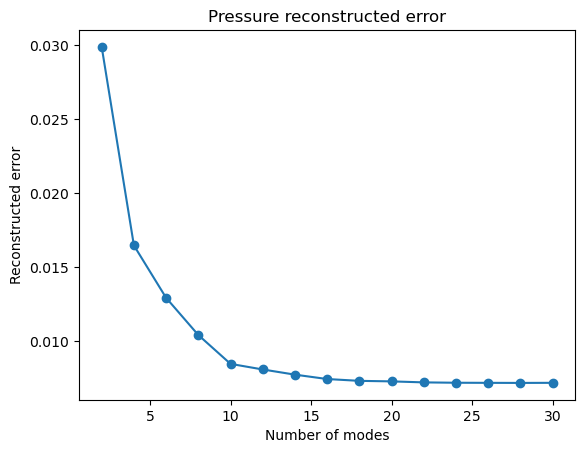

In [27]:
# print the error using 5 modes
p_error_list = np.array(p_error_list)
p_error_mean = np.mean(p_error_list, axis=1)

plt.plot(range(2, 32, 2), p_error_mean, marker='o')
plt.title('Pressure reconstructed error')
plt.xlabel('Number of modes')
plt.ylabel('Reconstructed error')
plt.show()

In [25]:
u_error_list = []

for i in range(2, 42, 5):

    # Evaluate POD on the velocity data
    u_POD = POD_eval(train_velocity, epsilon=i)

    # Define the GPR model
    gpr = GPR()

    # Perform PODI on the pressure data
    u_rom = PODI_rom(u_POD, gpr, train_design_parameters, train_velocity)

    # Predict the pressure data
    u_predict = u_rom.predict(test_design_parameters)

    # calculate the reconstrcuted error for each test data using mean squared error
    u_error_list.append(np.linalg.norm(test_velocity - u_predict.snapshots_matrix, axis=1) / np.linalg.norm(test_velocity, axis=1))

    # # plot the error
    # plt.bar([i for i in range(len(u_reconstructed_error))], u_reconstructed_error)
    # plt.title('Velocity reconstructed error')
    # plt.xlabel('Test data')
    # plt.ylabel('Reconstructed error')
    # plt.show()

Number of modes: 2
Number of modes: 7
Number of modes: 12
Number of modes: 17
Number of modes: 22
Number of modes: 27
Number of modes: 32
Number of modes: 37


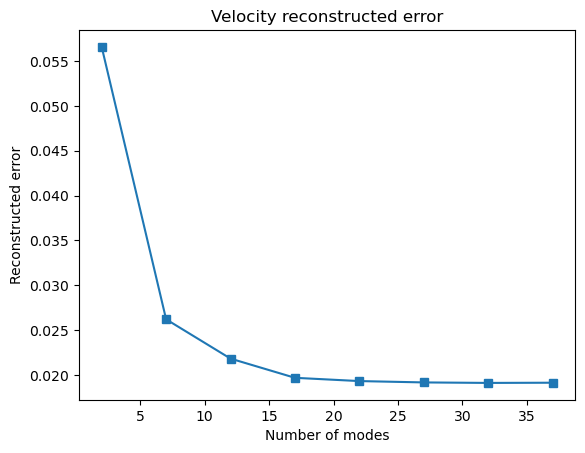

In [26]:
# print the error using different number of modes
u_error_list = np.array(u_error_list)
u_error_mean = np.mean(u_error_list, axis=1)

plt.plot(range(2, 42, 5), u_error_mean, marker='s')
plt.title('Velocity reconstructed error')
plt.xlabel('Number of modes')
plt.ylabel('Reconstructed error')
plt.show()

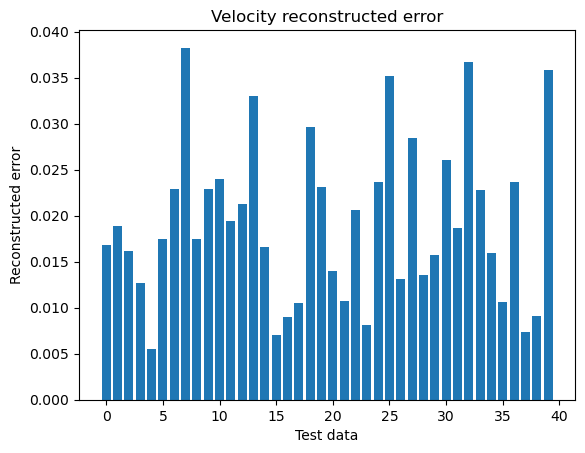

In [28]:
# plot the error of each case when using 22 modes
plt.bar([i for i in range(len(u_error_list[4]))], u_error_list[4])
plt.title('Velocity reconstructed error')
plt.xlabel('Test data')
plt.ylabel('Reconstructed error')
plt.show()

### 5. VTK visualization

In [29]:
# Evaluate POD on the velocity data
u_POD = POD_eval(train_velocity, epsilon=22)

# Define the GPR model
gpr = GPR()

# Perform PODI on the pressure data
u_rom = PODI_rom(u_POD, gpr, train_design_parameters, train_velocity)

# Predict the pressure data
u_predict = u_rom.predict(test_design_parameters)

Number of modes: 22


In [30]:
# Define a funtion to write the data into a VTK file
def vtk_writer(field_data, field_name, data_type,
               refVTM, save_path_name, points_data = None):
    # Add velocity data to each block within the MultiBlock dataset
    
    for block_i in range(refVTM.n_blocks):
        block = refVTM[block_i]
        if block is not None:
            if data_type == 'scalar':
                for data_i in range(len(field_name)):
                    block.cell_data[field_name[data_i]] = field_data[data_i]
            elif data_type == 'vector':
                for data_i in range(len(field_name)):
                    field = field_data[data_i].reshape(3, -1).T
                    block.cell_data[field_name[data_i]] = field 
            if points_data is not None:
                points = points_data.reshape(3, -1).T
                block.points = points

    # Save the modified VTM file
    output_vtm_file_path = f'{save_path_name}.vtm'
    refVTM.save(output_vtm_file_path)

In [18]:
# write the truth data, reconstructed data, and error into a VTK file
# Load the reference mesh VTM file
refVTM = pv.MultiBlock('simulation_data/refCase/VTK/refCase_0.vtm')
field_name = ['truth', 'reconstructed', 'error']
p_error_field = test_pressure - p_predict.snapshots_matrix

# loop all test data and write the data into VTK file
for i in range(len(test_pressure)):
    vtk_writer([test_pressure[i], p_predict.snapshots_matrix[i], p_error_field[i]], 
                field_name, 'scalar', refVTM, f'visualization_data/EZyRB_PODI_GPR/test_case_{i}_pressure', test_points[i])

In [32]:
# Write the velocity data into VTK file
refVTM = pv.MultiBlock('simulation_data/refCase/VTK/refCase_0.vtm')
field_name = ['truth', 'reconstructed', 'error']
u_error_field = test_velocity - u_predict.snapshots_matrix

# loop all test data and write the data into VTK file
for i in range(len(test_velocity)):
    vtk_writer([test_velocity[i], u_predict.snapshots_matrix[i], u_error_field[i]], 
                field_name, 'vector', refVTM, f'visualization_data/EZyRB_PODI_GPR/test_case_{i}_velocity', test_points[i])